## 01. Import libraries and data set

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
path = r'/Users/Dimitris/Desktop/CF Data Analytics/Data Immersion/Achievement 4/22-08-2022 Instacart Basket Analysis'

In [3]:
# Import the orders_products_customer_merged dataframe from the pickle file you saved

df_final = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared data', 'orders_products_customer_merged.pkl'))

In [4]:
# Display all columns in dataframe

pd.set_option('display.max_columns', None)

In [ ]:
df_final.head()
df_final.shape
df_final.info()

In [ ]:
# Change data types to help with memory management

df_final.astype({'order_id': 'int32'}).dtypes
df_final.astype({'order_number': 'int32'}).dtypes
df_final.astype({'order_number': 'int32'}).dtypes
df_final.astype({'orders_day_of_week': 'int16'}).dtypes
df_final.astype({'order_hour_of_day': 'int16'}).dtypes
df_final.astype({'days_since_prior_order': 'float16'}).dtypes
df_final.astype({'product_id': 'int16'}).dtypes
df_final.astype({'add_to_cart_order': 'int32'}).dtypes
df_final.astype({'reordered': 'int32'}).dtypes
df_final.astype({'department_id': 'float16'}).dtypes
df_final.astype({'prices': 'float16'}).dtypes
df_final.astype({'max_order': 'int32'}).dtypes
df_final.astype({'orders_mean_price': 'float16'}).dtypes
df_final.astype({'customer_order_frequency': 'float16'}).dtypes
df_final.astype({'age': 'int16'}).dtypes
df_final.astype({'dependants_number': 'int16'}).dtypes
df_final.astype({'income': 'int32'}).dtypes

In [8]:
# Drop columns 'Unnamed: 0_x', 'Unnamed: 0_y', 'aisle_id', '_merge', 'first_name' and 'last_name' as they are
# not useful for our analysis.

df_final = df_final.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y', 'aisle_id', '_merge', 'first_name', 'last_name'])

In [ ]:
df_final.shape

## Step 2 - Consider any security implications that might exist for this new data.

The data set contains PII because there is a number of colums in the data set that could potentially be used individually or in combination to identify a particular person e.g., first_name, last_name, age, state, dependants_number, family_status. Anyone with access to this data can use it identify a specific person. My approach would be to ask the senior members in my team for advice and any action taken should be compliant with GDPR or any other relevant laws and regulations. I have already deleted the first_name and last_name columns as they were not useful to my analysis.

## Step 3A - Create a regional segmentation of the data. Create a “Region” column.

In [10]:
# Create a list of regions 
northeast=['Maine','New Hampshire','Vermont','Massachusetts','Rhode Island','Connecticut','New York','Pennsylvania','New Jersey']
midwest=['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota','South Dakota','Nebraska','Kansas','Minnesota','Iowa','Missouri']
south=['Delaware','Maryland','District of Columbia','Virginia','West Virginia','North Carolina','South Carolina','Georgia','Florida','Kentucky', 'Tennessee','Mississippi','Alabama','Oklahoma','Texas','Arkansas','Louisiana']
west=['Idaho','Montana','Wyoming','Nevada','Utah','Colorado','Arizona','New Mexico','Alaska','Washington','Oregon','California','Hawaii']

In [11]:
# Create regional flags
df_final.loc[df_final['state'].isin(northeast), 'region'] = 'Region_1_Northeast'
df_final.loc[df_final['state'].isin(midwest), 'region'] = 'Region_2_Midwest'
df_final.loc[df_final['state'].isin(south), 'region'] = 'Region_3_South'
df_final.loc[df_final['state'].isin(west), 'region'] = 'Region_4_West'

In [ ]:
df_final['region'].value_counts(dropna = False)

## Step 3B - Determine whether there’s a difference in spending habits between the different U.S. regions.

In [ ]:
# Create a crosstab between the 'region' and the 'spending_flag' column

crosstab = pd.crosstab(df_final['region'], df_final['spending_flag'], dropna = False)

region	           High spender	Low spender
region_1_northeast	 108231	     5620168
region_2_midwest	 156041	     7447932
region_3_south	     199282	     9965751
region_4_west	     160357	     8140177

In [ ]:
# Count unique user IDs

df_final['user_id'].nunique()

In [15]:
# Group user IDs, average and total price by region

df_region_cust_price = df_final.groupby('region').agg({'user_id':['nunique'] ,'prices': ['mean', 'sum']})

In [ ]:
df_region_cust_price.head()

Region 3 - South has the highest number of customers. Regions 2 & 4 have a similar number of customers, whereas region 1 - Northeast has the lowest. The South region includes the highest number of States (17). In contrast, the Northeast region includes the lowest number of States (9). The South region's customer base is approximately 47% larger than the Northeast customer base.

The South region has the highest revenue and the Northeast region the lowest.

It is worth noting that the average spent per customer is highest in region 2 - Midwest (12.7) and the lowest in region 4 - West (11.3).

## Step 4 - Create an exclusion flag for low-activity customers

In [17]:
# Create an exclusion flag. Keep = 1, Exclude = 0

df_final.loc[df_final['order_number']>= 5,'exclusion_flag'] = '1'

In [18]:
df_final.loc[df_final['order_number']< 5,'exclusion_flag'] = '0'

In [19]:
# Create a data frame containing only the high-spending customers

df_final_high_spenders = df_final[df_final['exclusion_flag'] == '1']

In [20]:
# Create a data frame containing only the low-spending customers

df_final_low_spenders = df_final[df_final['exclusion_flag'] == '0']

In [ ]:
df_final_high_spenders.head()
df_final_high_spenders.shape

In [ ]:
df_final_low_spenders.head()
df_final_low_spenders.shape

In [24]:
# Export the newly created dataframe as final_low_spenders to pkl format

df_final_low_spenders.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'df_final_low_spenders.pkl'))

### From this point onward, I will be using the df_final_high_spenders data frame for my analysis.

## Step 5 - Create a profiling variable based on age, income, certain goods in the “department_id” column, and number of dependents. 

## Age profile

In [ ]:
# Create conditions for Age profile

df_final_high_spenders.loc[df_final_high_spenders['age'] > 61, 'age_group'] = 'Older'
df_final_high_spenders.loc[(df_final_high_spenders['age'] <= 59) & (df_final_high_spenders['age'] > 41 ), 'age_group']= 'Middle-aged'
df_final_high_spenders.loc[df_final_high_spenders['age'] <= 40, 'age_group'] = 'Young'

In [ ]:
df_final_high_spenders['age_group'].value_counts(dropna=False)

## Income profile

In [ ]:
# Create conditions for Income profile
df_final_high_spenders.loc[df_final_high_spenders['income'] > 90001, 'income_group'] = 'High income'
df_final_high_spenders.loc[(df_final_high_spenders['income'] <= 90000) & (df_final_high_spenders['income'] > 49999 ), 'income_group']= 'Average income'
df_final_high_spenders.loc[df_final_high_spenders['income'] <= 49999, 'income_group'] = 'Lower income'

In [ ]:
df_final_high_spenders['income_group'].value_counts(dropna=False)

## Customer with baby items profile

In [33]:
# Create conditions for customer with baby items profile. Yes = 1, No = 0

def baby(row):

    if row['department_id'] == 18:
        return 1
    else: return 0

In [ ]:
df_final_high_spenders['cust_baby_items'] = df_final_high_spenders.apply(baby, axis=1)

In [ ]:
df_final_high_spenders['cust_baby_items'].value_counts()

In [ ]:
df_final_high_spenders.info()

In [ ]:
# Change data types to help with memory management

df_final_high_spenders.astype({'order_id': 'int32'}).dtypes
df_final_high_spenders.astype({'order_number': 'int32'}).dtypes
df_final_high_spenders.astype({'order_number': 'int32'}).dtypes
df_final_high_spenders.astype({'orders_day_of_week': 'int16'}).dtypes
df_final_high_spenders.astype({'order_hour_of_day': 'int16'}).dtypes
df_final_high_spenders.astype({'days_since_prior_order': 'float16'}).dtypes
df_final_high_spenders.astype({'product_id': 'int16'}).dtypes
df_final_high_spenders.astype({'add_to_cart_order': 'int32'}).dtypes
df_final_high_spenders.astype({'reordered': 'int32'}).dtypes
df_final_high_spenders.astype({'department_id': 'float16'}).dtypes
df_final_high_spenders.astype({'prices': 'float16'}).dtypes
df_final_high_spenders.astype({'max_order': 'int32'}).dtypes
df_final_high_spenders.astype({'orders_mean_price': 'float16'}).dtypes
df_final_high_spenders.astype({'customer_order_frequency': 'float16'}).dtypes
df_final_high_spenders.astype({'age': 'int16'}).dtypes
df_final_high_spenders.astype({'dependants_number': 'int16'}).dtypes
df_final_high_spenders.astype({'income': 'int32'}).dtypes
df_final_high_spenders.astype({'cust_baby_items': 'int32'}).dtypes

In [87]:
# Create conditions for customer with deli items profile. Yes = 1, No = 0

def deli(row):

    if row['department_id'] == 20:
        return 1
    else: return 0

In [ ]:
df_final_high_spenders['deli'] = df_final_high_spenders.apply(deli, axis=1)

In [ ]:
df_final_high_spenders['deli'].value_counts()

In [99]:
# Create conditions for customer with alcohol items profile. Yes = 1, No = 0

def alcohol(row):

    if row['department_id'] == 5:
        return 1
    else: return 0

In [ ]:
df_final_high_spenders['alcohol'] = df_final_high_spenders.apply(alcohol, axis=1)

In [ ]:
df_final_high_spenders['alcohol'].value_counts()

In [ ]:
df_final_high_spenders.head()

## Step 6 - Create a visualization to show the distribution of profiles.

In [40]:
# Create a random sample

np.random.seed(4)
dev = np.random.rand(len(df_final_high_spenders)) <= 0.7

In [41]:
# Split the df_final_high_spenders dataframe into two samples. Store 70% in the dataframe big and 30% in small

big = df_final_high_spenders[dev]
small = df_final_high_spenders[~dev]

In [ ]:
# Check the results

len(df_final_high_spenders)
len(big) + len(small)

In [44]:
# Reduce the small sample to necessary columns

df_2 = small[['user_id','prices','order_hour_of_day','department_id','age','age_group','income','income_group','loyalty_flag','state','family_status','dependants_number','cust_baby_items','order_frequency_flag', 'price_range_loc']]

In [45]:
# Create a subset with unique user_id

df_unique_id = df_2.drop_duplicates(subset='user_id')

Text(0, 0.5, 'number of customers')

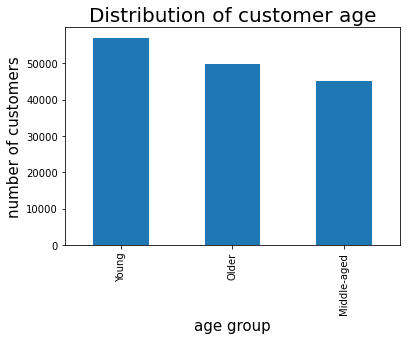

In [52]:
# Create a bar chart for the 'Age_group' profile

df_unique_id['age_group'].value_counts().plot.bar()
plt.title('Distribution of customer age', fontsize=20)
plt.xlabel('age group', fontsize=15)
plt.ylabel('number of customers', fontsize=15)

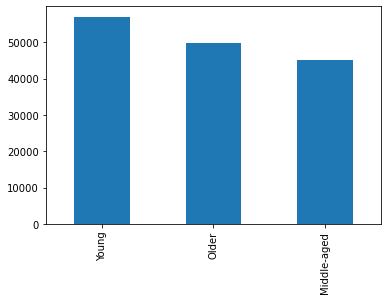

In [53]:
# Save bar chart in Jupyter's memory

bar = df_unique_id['age_group'].value_counts().plot.bar()

In [54]:
# Export bar chart

bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualisations', '4.10_bar_age_groups.png'))

Text(0, 0.5, 'number of customers')

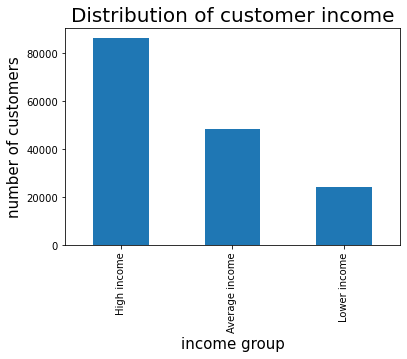

In [55]:
# Create a bar chart for the 'Income_group' profile

df_unique_id['income_group'].value_counts().plot.bar()
plt.title('Distribution of customer income', fontsize=20)
plt.xlabel('income group', fontsize=15)
plt.ylabel('number of customers', fontsize=15)

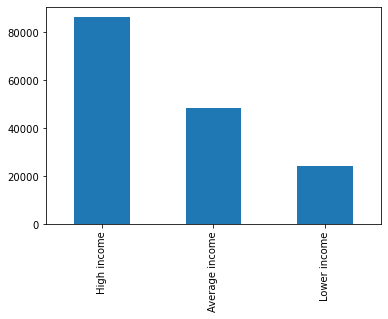

In [56]:
# Save bar chart in Jupyter's memory

bar = df_unique_id['income_group'].value_counts().plot.bar()

In [57]:
# Export bar chart

bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualisations', '4.10_bar_income_groups.png'))

<AxesSubplot:>

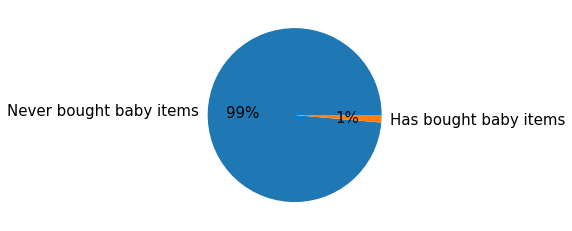

In [85]:
# Create a pie chart for the Customer with baby' profile
cust_baby_item = df_final_high_spenders['cust_baby_items'].value_counts()
pie = cust_baby_item.plot.pie(label='', labels=['Never bought baby items', 'Has bought baby items'],autopct=('%1.f%%'), textprops={'fontsize': 15})
pie

In [98]:
# Export pie chart
pie.figure.savefig(os.path.join(path, '04 Analysis', 'Visualisations', '4.10_pie_cust_with_baby_items_2.png'))

<AxesSubplot:>

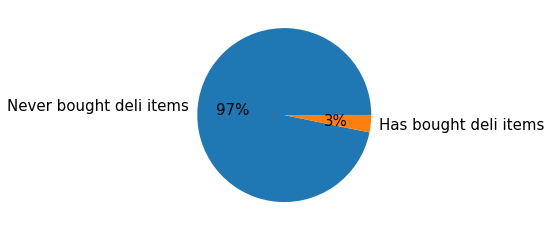

In [97]:
# Create a pie chart for the Deli profile
deli_cust = df_final_high_spenders['deli'].value_counts()
pie = deli_cust.plot.pie(label='', labels=['Never bought deli items', 'Has bought deli items'],autopct=('%1.f%%'), textprops={'fontsize': 15})
pie

In [ ]:
# Export pie chart
pie.figure.savefig(os.path.join(path, '04 Analysis', 'Visualisations', '4.10_pie_cust_with_deli_items.png'))

<AxesSubplot:>

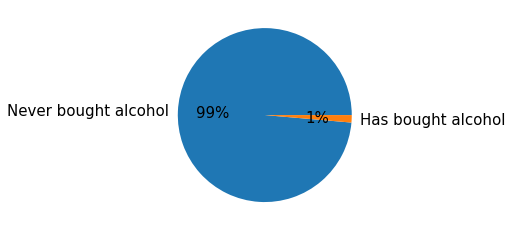

In [104]:
# Create a pie chart for the Alcohol profile
alcohol_cust = df_final_high_spenders['alcohol'].value_counts()
pie = cust_baby_item.plot.pie(label='', labels=['Never bought alcohol', 'Has bought alcohol'],autopct=('%1.f%%'), textprops={'fontsize': 15})
pie

In [105]:
# Export pie chart
pie.figure.savefig(os.path.join(path, '04 Analysis', 'Visualisations', '4.10_pie_cust_with_alcohol.png'))

<AxesSubplot:>

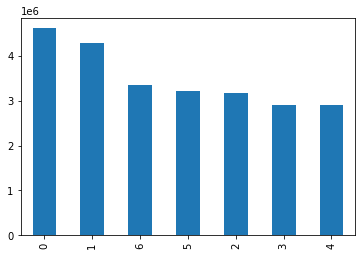

In [62]:
# Create a bar chart for busiest days of the week Q1

df_final_high_spenders['orders_day_of_week'].value_counts().plot.bar()

<AxesSubplot:>

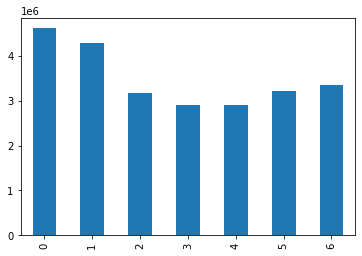

In [82]:
# Use the sort_index() function to rearrange the bars in the chart

df_final_high_spenders['orders_day_of_week'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

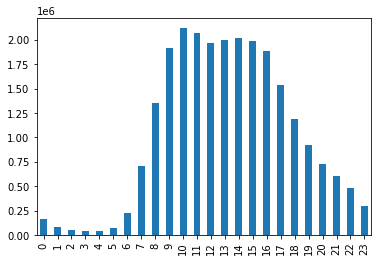

In [83]:
# Create a bar chart for busiest hours of the week Q1

df_final_high_spenders['order_hour_of_day'].value_counts().sort_index().plot.bar()

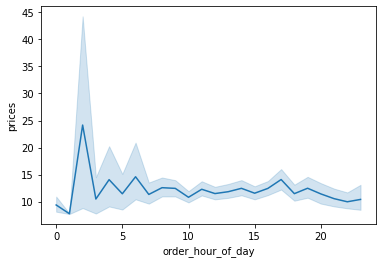

In [66]:
# Create a line chart showing product prices per hour of day Q2

line = sns.lineplot(data = df_2, x = 'order_hour_of_day',y = 'prices')

<AxesSubplot:>

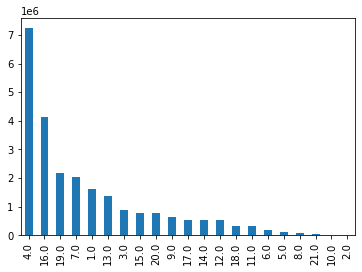

In [68]:
# Create a bar chart showing number of departmental sales Q4

df_final_high_spenders['department_id'].value_counts().plot.bar()

<AxesSubplot:>

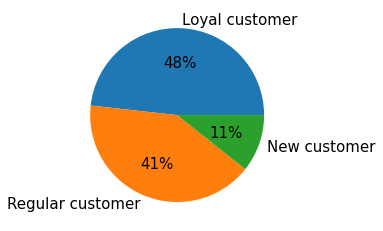

In [72]:
# Create a pie chart for the loyalty flag Q5a
loyalty_flag = df_unique_id['loyalty_flag'].value_counts()
pie = loyalty_flag.plot.pie(label='', labels=['Loyal customer', 'Regular customer', 'New customer'],autopct=('%1.f%%'), textprops={'fontsize': 15})
pie

In [73]:
# Explore ordering habits of high spenders based on loyalty status Q5b

df_final_high_spenders.groupby('loyalty_flag').agg({'order_number': ['mean'], 'prices': ['mean'], 'days_since_prior_order': ['mean']})

,order_number,prices,days_since_prior_order
,mean,mean,mean
loyalty_flag,,,
Loyal customer,34.939569,10.385370,5.954532
New customer,6.520857,13.283018,17.708879
Regular customer,14.769666,12.668943,11.917584


In [ ]:
# Explore ordering habits of high spenders based on region Q5c

df_final_high_spenders.groupby('region').agg({'order_number': ['mean'], 'prices': ['mean'], 'days_since_prior_order': ['mean']})

In [ ]:
# Number of customers per region


df_final_high_spenders.groupby('region').agg({'user_id': ['count']})

In [54]:
# Create crosstab 1. with customers per region and 2. high paying customers per region with order count and money spent

crosstab = pd.crosstab(df_final_high_spenders['region'],df_final_high_spenders['spending_flag'], dropna = False)
crosstab.to_clipboard()
crosstab = pd.crosstab(df_final_high_spenders['region'],df_final_high_spenders['spending_flag'], dropna = False)
crosstab = pd.crosstab(df_final_high_spenders['region'],df_final_high_spenders['loyalty_flag'], dropna = False)
crosstab.to_clipboard()


<AxesSubplot:>

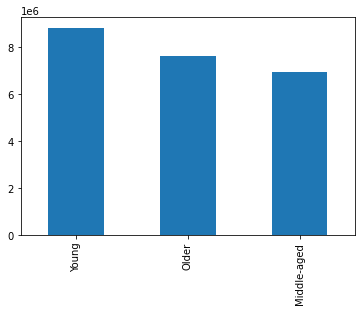

In [75]:
# Explore the connection between age and family status in terms of ordering habits Q5d

df_final_high_spenders['age_group'].value_counts().plot.bar()

<AxesSubplot:>

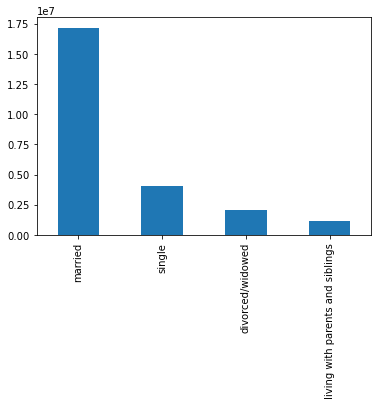

In [76]:
# Explore the connection between age and family status in terms of ordering habits Q5d

df_final_high_spenders['family_status'].value_counts().plot.bar()

## Step 7 - Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

### Age group profile

In [ ]:
df_final_high_spenders.groupby(['age_group']).agg({'customer_order_frequency':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

### Income group profile

In [ ]:
df_final_high_spenders.groupby(['income_group']).agg({'customer_order_frequency':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

### Baby items profile

In [ ]:
df_final_high_spenders.groupby(['cust_baby_items']).agg({'customer_order_frequency':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

In [ ]:
# Gender breakdown of frequent customers

df_final_high_spenders['gender'].value_counts(dropna = False)

In [ ]:
# Age breakdown of frequent customers

df_final_high_spenders['age'].value_counts(dropna = False)

In [ ]:
df_final_high_spenders['dependants_number'].value_counts(dropna = False)

In [ ]:
df_final_high_spenders['family_status'].value_counts(dropna = False)

In [ ]:
df_final_high_spenders['income'].value_counts(dropna = False)

<AxesSubplot:xlabel='age', ylabel='income'>

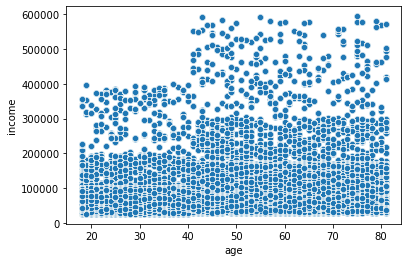

In [90]:
# Create a scatterplot of the “age” and “income” columns

sns.scatterplot(x = 'age', y = 'income',data = df_final_high_spenders)

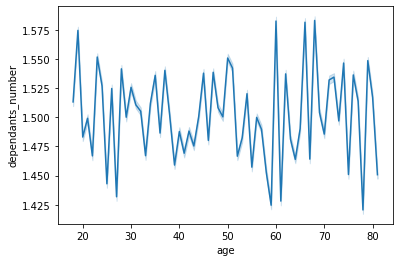

In [91]:
# Create a Line Chart (y = dependants_number, x = age)

line = sns.lineplot(data = df_final_high_spenders, x = 'age',y = 'dependants_number')

In [ ]:
df_final['price_range_loc'].value_counts(dropna = False)

In [56]:
# Create a subset with unique user_id. Q5c

df_unique_id_2 = df_final_high_spenders.drop_duplicates(subset='user_id')

In [59]:
# Group user IDs, average and total price by region for df_final_high_spenders. Q5c

df_region_cust_price = df_final_high_spenders.groupby('region').agg({'user_id':['nunique'] ,'prices': ['mean', 'sum']})

In [ ]:
df_region_cust_price

In [64]:
# Relationship between Age group and Number of Orders. Q5d

crosstab = pd.crosstab(df_final_high_spenders['age_group'],df_final_high_spenders['order_number'], dropna = False)
crosstab.to_clipboard()

In [66]:
# Relationship between Age group and Total spend. Q5d

crosstab = pd.crosstab(df_final_high_spenders['age_group'],df_final_high_spenders['prices'], dropna = False)
crosstab.to_clipboard()

In [68]:
# Relationship between Age group and Family status. Q5d

crosstab = pd.crosstab(df_final_high_spenders['age_group'],df_final_high_spenders['family_status'], dropna = False)
crosstab.to_clipboard()

In [70]:
# Relationship between Total spend and Family status. Q5d

crosstab = pd.crosstab(df_final_high_spenders['family_status'],df_final_high_spenders['prices'], dropna = False)
crosstab.to_clipboard()

In [ ]:
# Relationship between Order frequency, Prices and Family status. Q5d

df_final_high_spenders.groupby(['family_status']).agg({'customer_order_frequency':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

In [77]:
# Relationship between Price range and Family status. Q5e

crosstab = pd.crosstab(df_final_high_spenders['family_status'],df_final_high_spenders['price_range_loc'], dropna = False)
crosstab.to_clipboard()

In [81]:
# Relationship between income and Family status. Q5e

crosstab = pd.crosstab(df_final_high_spenders['family_status'],df_final_high_spenders['income_group'], dropna = False)
crosstab.to_clipboard()

In [83]:
# Relationship between income and price range. Q5e

crosstab = pd.crosstab(df_final_high_spenders['income_group'],df_final_high_spenders['price_range_loc'], dropna = False)
crosstab.to_clipboard()